In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os, sys, torch
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "../../../")))
from libs import data, hdc, helper, nn, poison
from cfgs.fedargs import *

ImportError: cannot import name 'train_test_split' from 'sklearn.model_selection' (unknown location)

In [3]:
use_cuda = fedargs.cuda and torch.cuda.is_available()
torch.manual_seed(fedargs.seed)
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {"num_workers": 1, "pin_memory": True} if use_cuda else {}

In [4]:
fedargs.dataset = 'fmnist'
train_data, test_data = data.load_dataset(fedargs.dataset, only_to_tensor = True)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=len(train_data), shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=len(test_data), shuffle=True, **kwargs)

In [5]:
fedargs.model = hdc.HDC(fedargs.one_d_len, fedargs.hdc_proj_len, len(fedargs.labels), device)

In [6]:
# Train    
train_acc = fedargs.model.train(train_loader, device)
#fedargs.model.load_state_dict(torch.load('hdc.pth'))

In [7]:
# Test, Plot and Log
test_acc = fedargs.model.test(test_loader, device)

In [8]:
#print(train_acc, test_acc)
print(test_acc)

66.18000030517578


In [9]:
hdc_train_vectors = fedargs.model.train_vectors

In [10]:
hdc_train_vectors

tensor([[757532.1875, 762289.8125, 766761.5625,  ..., 783198.5000,
         769961.7500, 766521.4375],
        [523049.4688, 520762.9062, 513555.4688,  ..., 528807.8750,
         520643.3125, 530514.6250],
        [870600.3125, 879480.7500, 897930.0000,  ..., 901354.8750,
         884390.3125, 882305.9375],
        ...,
        [379015.3438, 394346.1875, 380232.6562,  ..., 401684.5000,
         369939.2188, 384932.5938],
        [826839.6875, 815530.0625, 831551.3750,  ..., 844027.9375,
         817115.9375, 818017.8125],
        [719231.0625, 702858.1250, 702974.5000,  ..., 703490.3750,
         699718.1875, 694143.5625]])

In [11]:
model = nn.ModelMNIST()

In [12]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1024, shuffle=True, **kwargs)

In [13]:
'''
# Train
from tqdm import tqdm

fedargs.epochs = 5
fedargs.local_rounds = 1
for epoch in tqdm(range(fedargs.epochs)):
    _, model, loss = fedargs.train_func(model, train_loader, 
                                        fedargs.learning_rate,
                                        fedargs.weight_decay,
                                        fedargs.local_rounds, device)
torch.save(model.state_dict(), 'nn.pth')                                        
'''
model.load_state_dict(torch.load('nn-fm.pth'))
model.eval()

ModelMNIST(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [14]:
test_output = fedargs.eval_func(model, test_loader, device)
print(test_output)

{'test_loss': 0.35231710205078126, 'correct': 8717, 'accuracy': 87.17}


In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as f

def view_classify(img, ps, version="MNIST"):
    ps = ps.data.numpy().squeeze() 
    print('Predict class confidence:',ps)
    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    
def predict(model, img, view = True):
    with torch.no_grad():
        logits = model.forward(img)

    ps = f.softmax(logits, dim=1)
    if view:
        view_classify(img.view(1, 28, 28), ps)
    
    _, label = torch.max(ps, 1)
    return label 

Predict class confidence: [1.4230066e-04 1.0217686e-06 6.7592075e-05 9.5027559e-07 8.2093165e-06
 9.9482769e-01 1.0294825e-05 4.6294699e-03 5.2817162e-05 2.5960724e-04]


tensor([5])

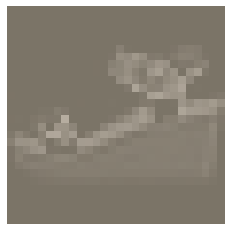

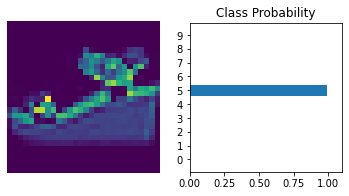

In [16]:
image, label = next(iter(test_loader))
lbl = label[0]
helper.imshow(image[0])
img = image[0].unsqueeze(0)
predict(model, img)

In [17]:
img_enc = img.reshape(1, 784) @ fedargs.model.proj
img_enc.size()

torch.Size([1, 10000])

Predict class confidence: [1.4230378e-04 1.0216457e-06 6.7595669e-05 9.5017663e-07 8.2072411e-06
 9.9482757e-01 1.0293047e-05 4.6295994e-03 5.2802749e-05 2.5960550e-04]


tensor([5])

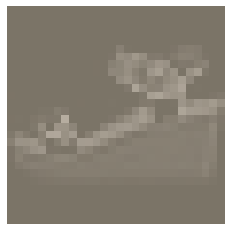

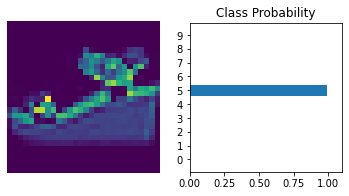

In [18]:
dec_img = img_enc @ fedargs.model.proj_inv
dec_img = dec_img.view(1, 28, 28)
helper.imshow(dec_img)
dec_img = dec_img.unsqueeze(0)
predict(model, dec_img)

In [19]:
from libs import sim
print(sim.cosine_similarity(img.reshape(784), dec_img.reshape(784)))

1.0000005


In [56]:
%%time
import copy

b_arr = fedargs.model.train_vectors[8]
c_arr = img_enc.reshape(10000)
p_arr = copy.deepcopy(c_arr)

dot_mb = 1 * sim.dot(b_arr, c_arr)
norm_b = sim.norm(b_arr)
norm_c = sim.norm(c_arr)
norm_m = norm_c
sim_mg = 1

kwargs = {"scale_norm": 10}

def get_img(p_arr):
    p_arr = p_arr.reshape(1, 10000)
    p_img = p_arr @ fedargs.model.proj_inv
    p_img = p_img.view(1, 28, 28)
    p_img = p_img.unsqueeze(0)
    return p_img

count_m = 0
count_t = 0
c_images = []
for index in range(10000):
    p_arr, dot_mb, norm_m, sim_mg, updated = sim.cosine_coord_vector_adapter(b_arr, p_arr, index, dot_mb, norm_m, sim_mg, c_arr, norm_c, norm_b, **kwargs)
    p_img = get_img(p_arr)
    _lbl = predict(model, p_img, False)
    if lbl != _lbl:
        c_images.append(p_img)
        count_m = count_m + 1
        if _lbl == 8:
            count_t = count_t + 1
print(count_m, count_t)

7207 7207
CPU times: user 17min 42s, sys: 148 ms, total: 17min 42s
Wall time: 19 s


Predict class confidence: [9.7178100e-03 2.0395495e-07 1.3529285e-03 4.2328943e-04 3.7873750e-05
 2.9198192e-02 5.3291215e-04 1.5782988e-04 9.5857853e-01 4.5804256e-07]


tensor([8])

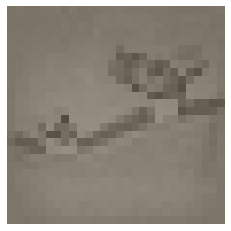

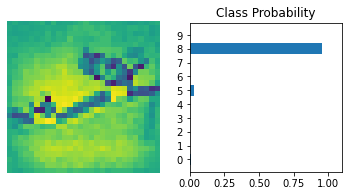

In [57]:
helper.imshow(p_img.squeeze(0))
predict(model, p_img)